<a href="https://colab.research.google.com/github/delowerhossentuhin/CVPR/blob/main/MID/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
import cv2
import numpy as np
import matplotlib.pyplot as plt
from base64 import b64decode
from scipy.ndimage import measurements


In [2]:
drive.mount("/content/drive")
model = keras.models.load_model("/content/drive/MyDrive/Project and Coding/Computer Vision and Pattern Recognition/MNist --- Train and Test/mnist_model.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
(X_train,Y_train),(X_test,Y_test) = mnist.load_data()
X_test = X_test.reshape(-1,28*28).astype("float32")/255.0
# X_test = X_test.reshape(-1, 28, 28, 1) / 255.0

train_loss, train_acc = model.evaluate(X_test,Y_test)
print(train_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9754 - loss: 0.0942
0.9771999716758728


---
# **Capture Image (two options)**


---






In [4]:
# --- Option A: Local Webcam (works in VS Code / Jupyter Notebook) ---
def capture_local_webcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot open camera")
        return None
    ret, frame = cap.read()
    cap.release()
    if not ret:
        print("Failed to capture frame")
        return None
    cv2.imwrite("captured_digit.png", frame)
    return "captured_digit.png"

# --- Option B: Google Colab Webcam ---
def capture_colab_webcam():
    from IPython.display import display, Javascript
    from google.colab.output import eval_js
    from base64 import b64decode

    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
            await new Promise((resolve) => capture.onclick = resolve);
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();
            return canvas.toDataURL('image/jpeg', 0.8);
        }
    ''')
    display(js)
    data = eval_js('takePhoto()')
    binary = b64decode(data.split(',')[1])
    with open("captured_digit.png", 'wb') as f:
        f.write(binary)
    return "captured_digit.png"

---
# **Image Preprocessing Function**


---



In [5]:
def preprocess(img):
    # Step 1: Threshold + invert
    img_thresh = cv2.adaptiveThreshold(img, 255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV,
                                       11, 2)
    # Step 2: remove small noise
    kernel = np.ones((2,2), np.uint8)
    img_thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kernel)
    # Step 3: Crop bounding box
    coords = cv2.findNonZero(img_thresh)
    if coords is None:
        raise ValueError("No digit detected. Try again with clearer input.")
    x, y, w, h = cv2.boundingRect(coords)
    img_crop = img_thresh[y:y+h, x:x+w]
    # Step 4: Resize to 20x20
    if w > h:
        scale = 20.0 / w
        new_w = 20
        new_h = int(h * scale)
    else:
        scale = 20.0 / h
        new_h = 20
        new_w = int(w * scale)
    img_resized = cv2.resize(img_crop, (new_w, new_h), interpolation=cv2.INTER_AREA)
    # Step 5: Pad to 28x28
    top = (28 - new_h) // 2
    bottom = 28 - new_h - top
    left = (28 - new_w) // 2
    right = 28 - new_w - left
    img_padded = cv2.copyMakeBorder(img_resized, top, bottom, left, right,
                                    cv2.BORDER_CONSTANT, value=0)
    # Step 6: Center using center of mass
    cy, cx = measurements.center_of_mass(img_padded)
    rows, cols = img_padded.shape
    shiftx = np.round(cols/2 - cx).astype(int)
    shifty = np.round(rows/2 - cy).astype(int)
    M = np.float32([[1, 0, shiftx], [0, 1, shifty]])
    img_shifted = cv2.warpAffine(img_padded, M, (cols, rows), borderValue=0)
   # Flatten and normalize
    img_flat = img_shifted.astype('float32').reshape(1, 28*28) / 255.0
    return img_flat, img_thresh, img_shifted

---
# **Choose Environment**


---



In [6]:
try:
    from google.colab import drive
    is_colab = True
except ImportError:
    is_colab = False
if is_colab:
    filename = capture_colab_webcam()
else:
    filename = capture_local_webcam()
print("Image captured:", filename)

<IPython.core.display.Javascript object>

Image captured: captured_digit.png


In [7]:
# Read raw image
# raw_img = cv2.imread(filename)
# raw_img_rgb = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
# plt.imshow(raw_img_rgb)

In [12]:
img = cv2.imread('captured_digit.png', cv2.IMREAD_GRAYSCALE)
img = img.astype(np.uint8)
img_flat, img_thresh, img_final = preprocess(img)

/tmp/ipython-input-2041877346.py:34: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  cy, cx = measurements.center_of_mass(img_padded)


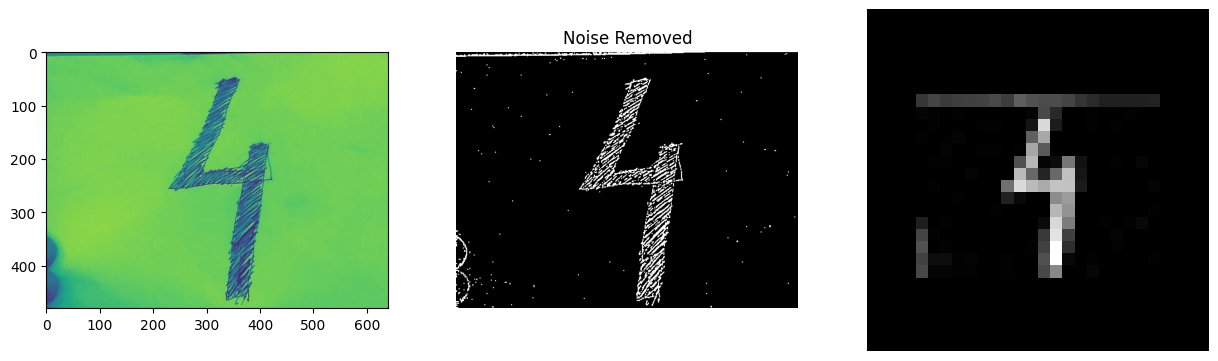

In [13]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(img)

plt.subplot(1,3,2)
plt.imshow(img_thresh, cmap='gray')
plt.axis('off')
plt.title("Noise Removed")

plt.subplot(1,3,3)
plt.imshow(img_final, cmap='gray')
plt.axis('off')
plt.show()

In [10]:
# img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (28, 28))
# img = cv2.bitwise_not(img)
# img = img / 255.0
# img = img.astype("float32")

# img = img.reshape(1,784)
# # img = img.reshape(1,28,28,1)

# plt.imshow(img.reshape(28,28), cmap="gray_r")
# plt.axis("off")
# plt.title("Preprocessed Digit")
# plt.show()

---
# **Prediction**


---



In [14]:
pred = model.predict(img_flat)
digit = np.argmax(pred)
print("Predicted Digit:", digit)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Predicted Digit: 4
